## 의사결정 트리(Titanic)

#### #01. 패키지 참조

In [1]:
import numpy as np
import seaborn as sb
import re # 정규표현식 연산 패키지
from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#### #02. 데이터 가져오기

csv 파일 읽기

In [3]:
train = read_csv("./train.csv")
test = read_csv("./test.csv")
print(train.shape, test.shape)
train.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터 프레임 원본 백업

In [4]:
original_train = train.copy()
original_test = test.copy()

훈련 데이터와 검증 데이터를 병합하여 전체 데이터셋 구성

In [5]:
full_data = [train, test]
print(type(full_data[0]))
full_data

<class 'pandas.core.frame.DataFrame'>


[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name     Sex   Age  SibSp  \
 0                              Braund, Mr. Owen Harris    male  22.0      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
 2                               Heikkinen, Miss. Laina  female  26.0      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
 4                             Allen, Mr. William Henry    male  35.0      0   
 ..                                               

#### #03. 데이터 전처리

객실 유무

In [7]:
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

가족 구성원 수

In [8]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

혼자 탑승했는지 여부

In [9]:
train['ISAlone'] = 0
train.loc[train['FamilySize'] == 1, 'ISAlone'] = 1
test['ISAlone'] = 0
test.loc[test['FamilySize'] == 1, 'ISAlone'] = 1

탑승지 결측치 처리

###### 소수의 결측치 데이터(train기준 2건)를 최빈값인 S로 대체

In [10]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

요금 데이터의 결측치 처리

In [11]:
train['Fare'] = train['Fare'].fillna(train['Fare'].median())
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

나이 데이터의 결측치 처리

###### 훈련 데이터

In [12]:
age_avg = train['Age'].mean()
age_std = train['Age'].std()
age_null_count = train['Age'].isnull().sum()
age_null_rnd_list = np.random.randint(age_avg - age_std,
age_avg + age_std, size=age_null_count)
# 결측치에 해당하는 행에 랜덤값을 채워준다.
train.loc[np.isnan(train['Age']), 'Age'] = age_null_rnd_list
train['Age'] = train['Age'].astype(int)

###### 검증 데이터

In [13]:
age_avg = test['Age'].mean()
age_std = test['Age'].std()
age_null_count = test['Age'].isnull().sum()
age_null_rnd_list = np.random.randint(age_avg - age_std,
age_avg + age_std, size=age_null_count)
# 결측치에 해당하는 행에 랜덤값을 채워준다.
test.loc[np.isnan(test['Age']), 'Age'] = age_null_rnd_list
test['Age'] = test['Age'].astype(int)

##### 정규 표현식 처리 함수
###### 이름에서 알파벳을 제외한 나머지 글자를 제외하고 어절 단위 리스트로 묶은 후 인덱스가 1인 위치를 리턴하는 함수

In [14]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""


In [15]:
train['Title'] = train['Name'].apply(get_title)
print(list(train['Title'].value_counts().index))

['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']


In [16]:
train['Title'] = train['Title'].replace(['Dr', 'Rev',
'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms',
'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], "Rare")

In [17]:
test['Title'] = test['Name'].apply(get_title)
test['Title'] = test['Title'].replace(['Dr', 'Rev',
'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms',
'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], "Rare")

데이터 라벨링

성별

In [18]:
train['Sex'] = train['Sex'].map({'female': 0, 'male': 1})
test['Sex'] = test['Sex'].map({'female': 0, 'male': 1})

호칭

In [20]:
train['Title'] = train['Title'].map({"Mr": 1, "Master": 2, "Mrs": 3,
"Miss": 4, "Rare": 5})
test['Title'] = test['Title'].map({"Mr": 1, "Master": 2, "Mrs": 3,
"Miss": 4, "Rare": 5})

탑승지

In [21]:
train['Embarked'] = train['Embarked'].map({"S": 0, "C": 1, "Q": 2})
test['Embarked'] = test['Embarked'].map({"S": 0, "C": 1, "Q": 2})

연령대 분할

In [22]:
train.loc[ train['Age'] <= 16, "Age"] = 0
train.loc[ (train['Age'] > 16) & (train['Age'] <= 32), "Age"] = 1
train.loc[ (train['Age'] > 32) & (train['Age'] <= 48), "Age"] = 2
train.loc[ (train['Age'] > 48) & (train['Age'] <= 64), "Age"] = 3
train.loc[ train['Age'] > 64, "Age"] = 4
test.loc[ test['Age'] <= 16, "Age"] = 0
test.loc[ (test['Age'] > 16) & (test['Age'] <= 32), "Age"] = 1
test.loc[ (test['Age'] > 32) & (test['Age'] <= 48), "Age"] = 2
test.loc[ (test['Age'] > 48) & (test['Age'] <= 64), "Age"] = 3
test.loc[ test['Age'] > 64, "Age"] = 4


탑승 요금 분할

탑승 요금의 최대/최소, 사분위 수 확인

In [23]:
train['Fare'].quantile([0, 0.25, 0.5, 0.75, 1.0])

0.00      0.0000
0.25      7.9104
0.50     14.4542
0.75     31.0000
1.00    512.3292
Name: Fare, dtype: float64

In [24]:
train.loc[ train['Fare'] <= 7.91, "Fare"] = 0
train.loc[ (train['Fare'] > 7.91) & (train['Fare'] <= 14.454), "Fare"] = 1
train.loc[ (train['Fare'] > 14.454) & (train['Fare'] <= 31), "Fare"] = 2
train.loc[ train['Fare'] > 31, "Fare"] = 3
test.loc[ test['Fare'] <= 7.91, "Fare"] = 0
test.loc[ (test['Fare'] > 7.91) & (test['Fare'] <= 14.454), "Fare"] = 1
test.loc[ (test['Fare'] > 14.454) & (test['Fare'] <= 31), "Fare"] = 2
test.loc[ test['Fare'] > 31, "Fare"] = 3

불필요한 필드 제거

In [25]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,ISAlone,Title
0,0,3,1,1,0,0.0,0,0,2,0,1
1,1,1,0,2,0,3.0,1,1,2,0,3
2,1,3,0,1,0,1.0,0,0,1,1,4
3,1,1,0,2,0,3.0,0,1,2,0,3
4,0,3,1,2,0,1.0,0,0,1,1,1


전처리 결과 확인

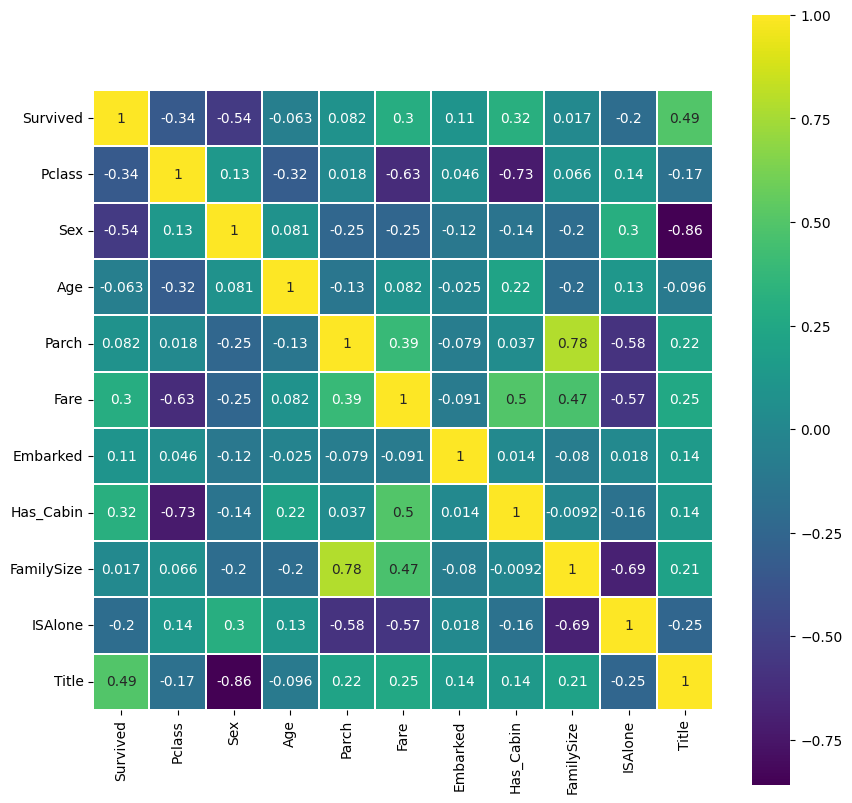

In [26]:
plt.figure(figsize=(10, 10))
sb.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True,
cmap=plt.cm.viridis, linecolor='white', annot=True)
plt.show()
plt.close()